# Lab 3: Customer Segmentation with K-Means on UCI Bank Marketing

This lab extends the exploratory (Lab 1) and preparation (Lab 2) work by running a full clustering study over the engineered Bank Marketing dataset. We focus on discovering actionable segments, validating the stability of the clusters, and translating the findings into marketing guidance.

## 1. Data Preparation & Quality Checks

We start by reloading the prepared dataset, validating data quality signals, and refreshing ourselves on the distribution of the most critical variables before running K-Means.

### 1.1 Import modules and load the prepared dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
    davies_bouldin_score,
    pairwise_distances_argmin_min,
)
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.utils import resample

from scipy.stats import f_oneway

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

prepared_path = Path("bank_marketing_prepared.csv")
if not prepared_path.exists():
    raise FileNotFoundError("Prepared dataset not found. Run Lab 2 preprocessing first.")

df = pd.read_csv(prepared_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (4478, 41)


,age,education,balance,day,month,campaign,previous,y,pdays_recency,pdays_missing,...,contact_telephone,balance_outlier_flag,campaign_outlier_flag,campaign_unit,previous_unit,pdays_unit,balance_per_call,contact_intensity_norm,month_sin,month_cos
0,-1.056270,0.0,1.529194,0.600000,10.0,0.000000,-0.426156,0,-0.169443,1,...,False,0,0,0.000000,-0.929242,-0.369473,1.933921,0.060150,-8.660254e-01,0.500000
1,-0.772583,1.0,1.908361,0.333333,5.0,0.000000,2.648229,0,1.063669,0,...,False,1,0,0.000000,0.927947,0.372712,5.638855,0.010025,5.000000e-01,-0.866025
2,-0.583458,2.0,1.459719,0.500000,4.0,0.000000,0.897909,0,0.996749,0,...,False,0,0,0.000000,0.669309,0.742984,1.394595,0.028822,8.660254e-01,-0.500000
3,-1.056270,2.0,1.480251,0.066667,6.0,0.916291,-0.426156,0,0.488857,1,...,False,0,0,0.816239,-0.379623,0.435478,0.183889,0.248120,1.224647e-16,-1.000000
4,1.686036,1.0,1.208357,0.133333,5.0,0.000000,-0.426156,0,-0.577604,1,...,False,0,0,0.000000,-0.593699,-0.804687,-0.271514,0.060150,5.000000e-01,-0.866025


### 1.2 Validate basic data quality signals

We confirm data types, look for missing values, and inspect duplicates to ensure the dataset is ready for clustering.

In [2]:
quality_report = {
    "dtypes": df.dtypes,
    "missing": df.isna().sum(),
    "duplicate_rows": df.duplicated().sum(),
}
quality_report

{'dtypes': age                       float64
 education                 float64
 balance                   float64
 day                       float64
 month                     float64
 campaign                  float64
 previous                  float64
 y                           int64
 pdays_recency             float64
 pdays_missing               int64
 contacted_before            int64
 recent_contact_90d          int64
 poutcome_missing            int64
 poutcome_success_flag       int64
 poutcome_failure_flag       int64
 contact_missing             int64
 job_blue-collar              bool
 job_entrepreneur             bool
 job_housemaid                bool
 job_management               bool
 job_retired                  bool
 job_self-employed            bool
 job_services                 bool
 job_student                  bool
 job_technician               bool
 job_unemployed               bool
 marital_married              bool
 marital_single               bool
 default_y

### 1.3 Explore key distributions and correlations

Histograms and correlation heatmaps help us spot skewed variables and residual relationships that can influence cluster structure.

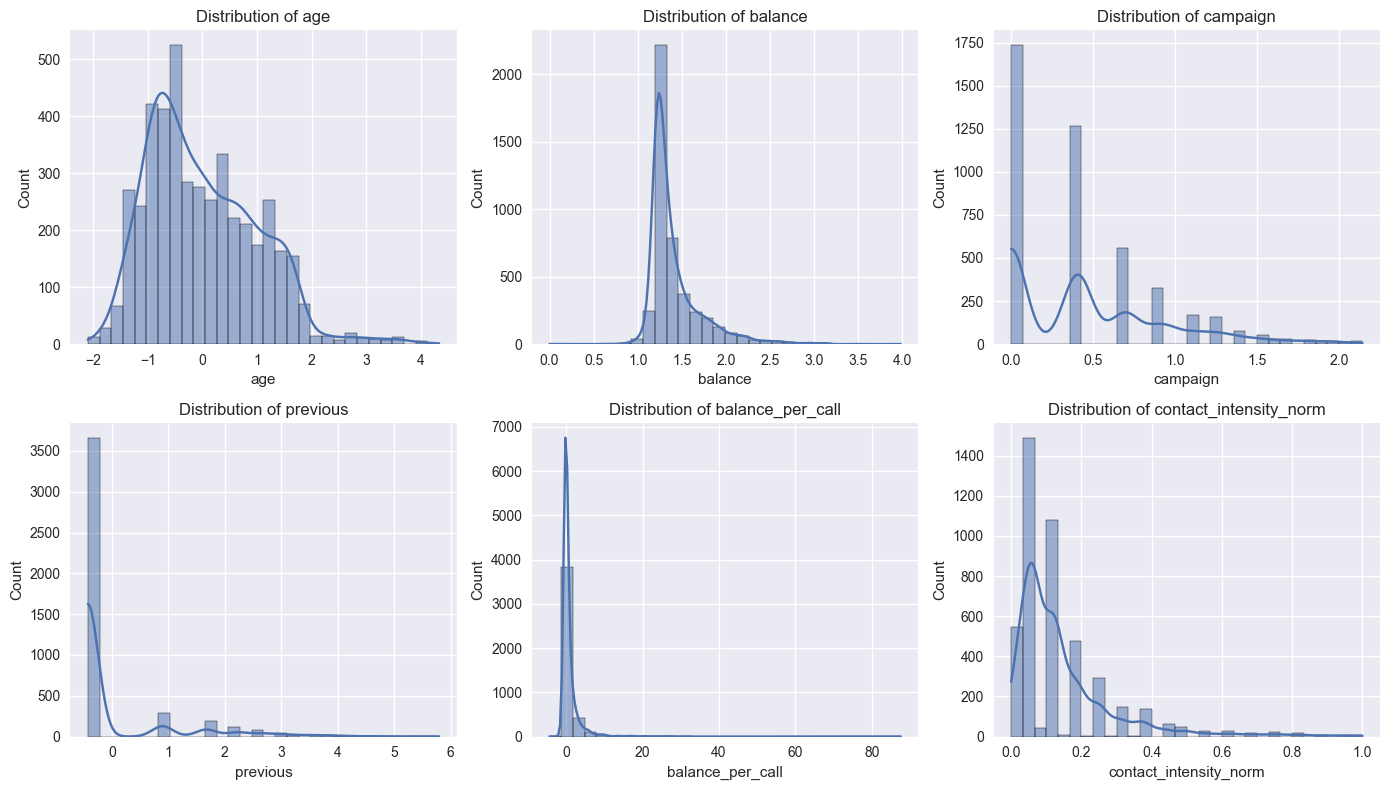

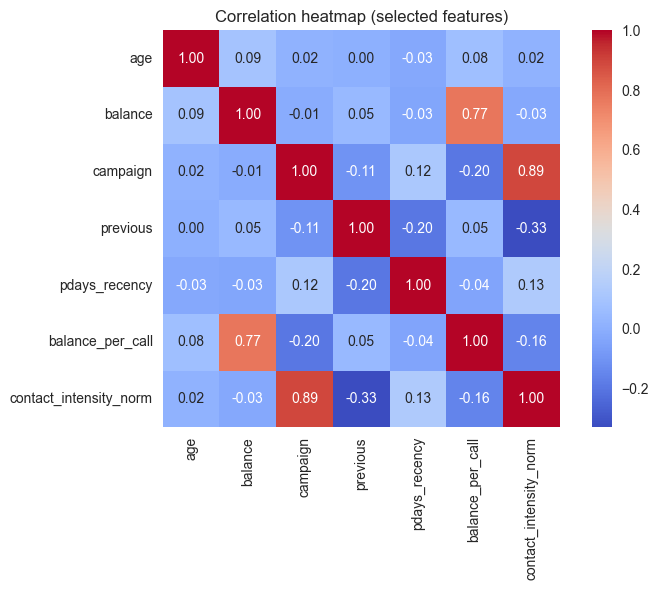

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
focus_features = ["age", "balance", "campaign", "previous", "balance_per_call", "contact_intensity_norm"]
for ax, feature in zip(axes.flatten(), focus_features):
    sns.histplot(df[feature], kde=True, ax=ax, bins=30)
    ax.set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

corr_matrix = df[["age", "balance", "campaign", "previous", "pdays_recency", "balance_per_call", "contact_intensity_norm"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation heatmap (selected features)")
plt.tight_layout()
plt.show()

## 2. Feature Scaling & Candidate K Search

Next we standardise the feature space (excluding the subscription target) and evaluate multiple cluster counts (k = 2–15) using several internal validation metrics.

### 2.1 Prepare feature matrix for clustering

In [4]:
feature_columns = [col for col in df.columns if col != "y"]
X = df[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)
print(f"Feature matrix shape: {X_scaled_df.shape}")

Feature matrix shape: (4478, 40)


### 2.2 Evaluate multiple k values with internal metrics

In [5]:
def evaluate_k_candidates(X_array, k_values, random_state=42):
    records = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = kmeans.fit_predict(X_array)
        inertia = kmeans.inertia_
        silhouette = silhouette_score(X_array, labels) if k > 1 else np.nan
        calinski = calinski_harabasz_score(X_array, labels) if k > 1 else np.nan
        davies = davies_bouldin_score(X_array, labels) if k > 1 else np.nan
        records.append({
            "k": k,
            "inertia": inertia,
            "silhouette": silhouette,
            "calinski_harabasz": calinski,
            "davies_bouldin": davies,
        })
    return pd.DataFrame(records)

k_range = range(2, 16)
k_metrics = evaluate_k_candidates(X_scaled, k_range)
k_metrics

,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,152627.275709,0.253785,776.934748,1.867647
1,3,143776.207093,0.200748,550.033543,1.773937
2,4,136683.425090,0.101185,463.020305,2.583744
3,5,130690.088767,0.099109,414.390630,2.422458
4,6,125317.881928,0.109483,383.988411,2.432599
5,7,121009.622614,0.103033,357.838619,2.251683
6,8,117659.561777,0.109804,333.563029,2.291457
7,9,113374.560384,0.117424,323.944332,2.073620
8,10,110994.448346,0.101035,304.704894,2.227908
9,11,107427.384087,0.105160,298.109200,2.023274


### 2.3 Visualise the elbow/metric curves

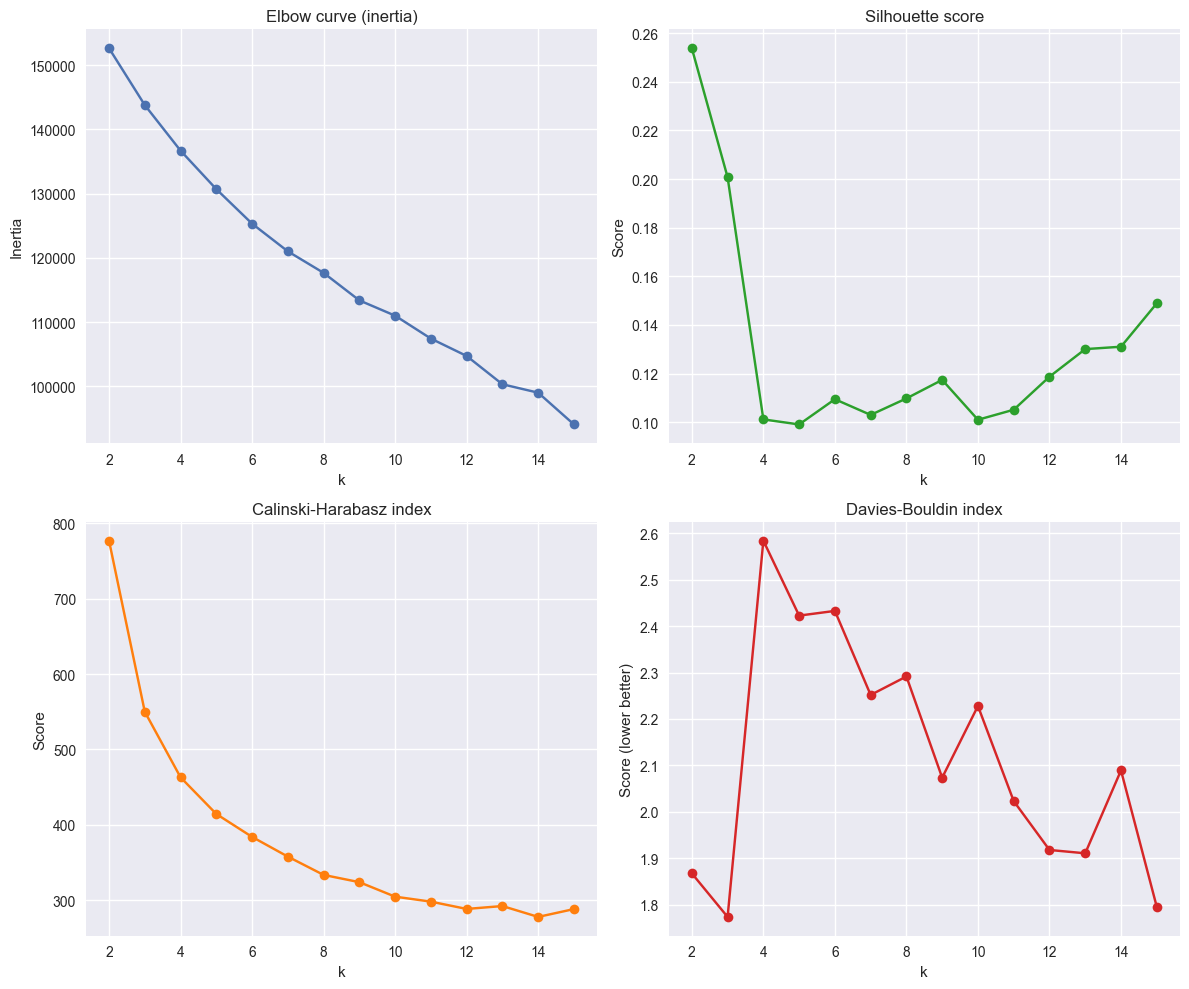

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
axes[0].plot(k_metrics["k"], k_metrics["inertia"], marker="o")
axes[0].set_title("Elbow curve (inertia)")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")

axes[1].plot(k_metrics["k"], k_metrics["silhouette"], marker="o", color="tab:green")
axes[1].set_title("Silhouette score")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Score")

axes[2].plot(k_metrics["k"], k_metrics["calinski_harabasz"], marker="o", color="tab:orange")
axes[2].set_title("Calinski-Harabasz index")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Score")

axes[3].plot(k_metrics["k"], k_metrics["davies_bouldin"], marker="o", color="tab:red")
axes[3].set_title("Davies-Bouldin index")
axes[3].set_xlabel("k")
axes[3].set_ylabel("Score (lower better)")

plt.tight_layout()
plt.show()

### 2.4 Combine metric rankings to pick a candidate k

In [7]:
metrics_ranked = k_metrics.copy()
metrics_ranked["silhouette_rank"] = metrics_ranked["silhouette"].rank(ascending=False)
metrics_ranked["calinski_rank"] = metrics_ranked["calinski_harabasz"].rank(ascending=False)
metrics_ranked["davies_rank"] = metrics_ranked["davies_bouldin"].rank(ascending=True)
metrics_ranked["composite_rank"] = metrics_ranked[["silhouette_rank", "calinski_rank", "davies_rank"]].mean(axis=1)
metrics_ranked.sort_values("composite_rank", inplace=True)
metrics_ranked

,k,inertia,silhouette,calinski_harabasz,davies_bouldin,silhouette_rank,calinski_rank,davies_rank,composite_rank
0,2,152627.275709,0.253785,776.934748,1.867647,1.0,1.0,3.0,1.666667
1,3,143776.207093,0.200748,550.033543,1.773937,2.0,2.0,1.0,1.666667
13,15,94064.169300,0.148894,288.256240,1.795771,3.0,13.0,2.0,6.000000
11,13,100319.024208,0.130081,292.272876,1.910849,5.0,11.0,4.0,6.666667
7,9,113374.560384,0.117424,323.944332,2.073620,7.0,8.0,7.0,7.333333
10,12,104723.561106,0.118738,288.425583,1.918036,6.0,12.0,5.0,7.666667
6,8,117659.561777,0.109804,333.563029,2.291457,8.0,7.0,11.0,8.666667
9,11,107427.384087,0.105160,298.109200,2.023274,10.0,10.0,6.0,8.666667
12,14,99006.807577,0.131068,277.856300,2.089311,4.0,14.0,8.0,8.666667
4,6,125317.881928,0.109483,383.988411,2.432599,9.0,5.0,13.0,9.000000


### 2.5 Inspect silhouette structure for the top-ranked solution

Selected k based on composite ranking: 2
Average silhouette score for k=2: 0.254


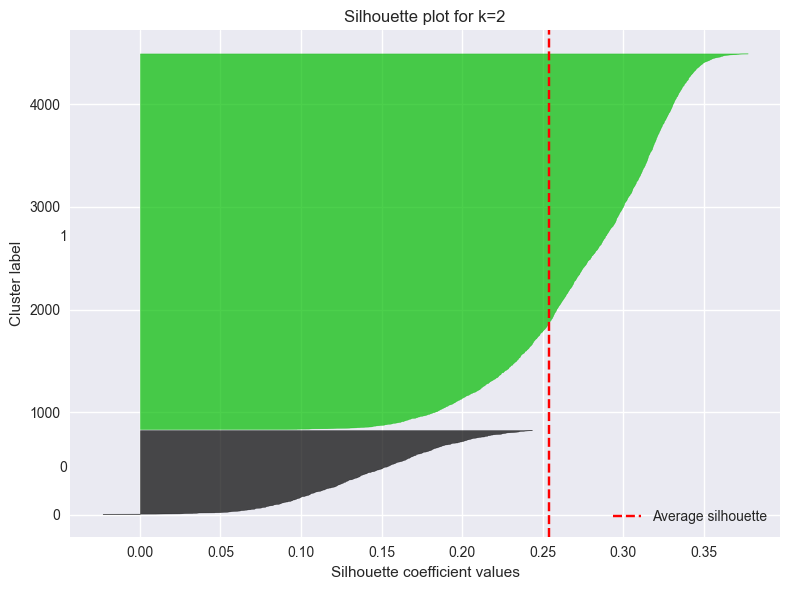

In [8]:
best_k = int(metrics_ranked.iloc[0]["k"])
print(f"Selected k based on composite ranking: {best_k}")

kmeans_preview = KMeans(n_clusters=best_k, n_init=10, random_state=42)
preview_labels = kmeans_preview.fit_predict(X_scaled)
preview_silhouette = silhouette_score(X_scaled, preview_labels)
print(f"Average silhouette score for k={best_k}: {preview_silhouette:.3f}")

silhouette_vals = silhouette_samples(X_scaled, preview_labels)
y_lower = 10
fig, ax = plt.subplots(figsize=(8, 6))
for cluster in range(best_k):
    cluster_vals = silhouette_vals[preview_labels == cluster]
    cluster_vals.sort()
    size = cluster_vals.shape[0]
    y_upper = y_lower + size
    color = plt.cm.nipy_spectral(float(cluster) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size, str(cluster))
    y_lower = y_upper + 10

ax.axvline(preview_silhouette, color="red", linestyle="--", label="Average silhouette")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_title(f"Silhouette plot for k={best_k}")
ax.legend()
plt.tight_layout()
plt.show()

## 3. Cluster Validation & Stability Checks

We stress-test the chosen k using bootstrapping, subsampling, and varying random seeds. Confidence intervals help quantify stability.

### 3.1 Bootstrap and subsample validation

In [9]:
def collect_validation_metrics(X_array, k, method="bootstrap", n_iter=30, sample_frac=0.8, random_state=42):
    rng = np.random.default_rng(random_state)
    results = []
    n_samples = X_array.shape[0]
    sample_size = int(sample_frac * n_samples)
    for i in range(n_iter):
        if method == "bootstrap":
            indices = rng.integers(0, n_samples, size=sample_size)
        else:
            indices = rng.choice(n_samples, size=sample_size, replace=False)
        X_sample = X_array[indices]
        model = KMeans(n_clusters=k, n_init=10, random_state=random_state + i)
        labels = model.fit_predict(X_sample)
        sil = silhouette_score(X_sample, labels)
        ch = calinski_harabasz_score(X_sample, labels)
        db = davies_bouldin_score(X_sample, labels)
        results.append({
            "iteration": i,
            "method": method,
            "silhouette": sil,
            "calinski_harabasz": ch,
            "davies_bouldin": db,
        })
    return pd.DataFrame(results)

bootstrap_results = collect_validation_metrics(X_scaled, best_k, method="bootstrap")
subsample_results = collect_validation_metrics(X_scaled, best_k, method="subsample")
validation_results = pd.concat([bootstrap_results, subsample_results], ignore_index=True)
validation_results.head()

,iteration,method,silhouette,calinski_harabasz,davies_bouldin
0,0,bootstrap,0.251231,628.404461,1.879392
1,1,bootstrap,0.256705,623.594154,1.866049
2,2,bootstrap,0.254184,640.981957,1.839083
3,3,bootstrap,0.254160,615.905798,1.857285
4,4,bootstrap,0.251407,615.195612,1.852942


### 3.2 Confidence intervals for validation metrics

In [10]:
def summarise_ci(df_metrics):
    summary_rows = []
    for method, grp in df_metrics.groupby("method"):
        for metric in ["silhouette", "calinski_harabasz", "davies_bouldin"]:
            values = grp[metric].values
            ci_low, ci_high = np.percentile(values, [2.5, 97.5])
            summary_rows.append({
                "method": method,
                "metric": metric,
                "mean": values.mean(),
                "std": values.std(ddof=1),
                "ci_2.5": ci_low,
                "ci_97.5": ci_high,
            })
    return pd.DataFrame(summary_rows)

ci_summary = summarise_ci(validation_results)
ci_summary

,method,metric,mean,std,ci_2.5,ci_97.5
0,bootstrap,silhouette,0.253899,0.003029,0.248902,0.259756
1,bootstrap,calinski_harabasz,618.822179,15.307123,597.938903,645.336724
2,bootstrap,davies_bouldin,1.866230,0.014511,1.833891,1.885919
3,subsample,silhouette,0.253552,0.001436,0.250551,0.255619
4,subsample,calinski_harabasz,623.103659,6.662764,610.961745,635.518350
5,subsample,davies_bouldin,1.868068,0.008013,1.850200,1.880689


### 3.3 Sensitivity to random initialisation

In [11]:
random_state_metrics = []
for seed in range(20):
    model = KMeans(n_clusters=best_k, n_init=10, random_state=seed)
    labels = model.fit_predict(X_scaled)
    random_state_metrics.append({
        "random_state": seed,
        "silhouette": silhouette_score(X_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, labels),
    })

random_state_df = pd.DataFrame(random_state_metrics)
random_state_df.describe().T

,count,mean,std,min,25%,50%,75%,max
random_state,20.0,9.500000,5.916080e+00,0.000000,4.750000,9.500000,14.250000,19.000000
silhouette,20.0,0.253785,5.695324e-17,0.253785,0.253785,0.253785,0.253785,0.253785
calinski_harabasz,20.0,776.934748,1.166402e-13,776.934748,776.934748,776.934748,776.934748,776.934748
davies_bouldin,20.0,1.867647,2.278130e-16,1.867647,1.867647,1.867647,1.867647,1.867647


## 4. Final Model & Cluster Profiling

With validation completed, we fit the final model, attach cluster labels, and profile each segment from numeric and categorical angles.

### 4.1 Fit final K-Means and attach labels

In [12]:
kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_scaled)
df_clusters = df.copy()
df_clusters["cluster"] = cluster_labels

cluster_sizes = df_clusters["cluster"].value_counts().sort_index()
cluster_sizes

cluster
0     816
1    3662
Name: count, dtype: int64

### 4.2 Numeric summaries and conversion rates

In [13]:
numeric_features = [col for col in df.columns if col not in ["y"] and df[col].dtype != "uint8"]
cluster_numeric_summary = (
    df_clusters.groupby("cluster")
      .agg(
          cluster_size=("cluster", "size"),
          avg_age=("age", "mean"),
          avg_balance=("balance", "mean"),
          avg_campaign=("campaign", "mean"),
          avg_previous=("previous", "mean"),
          avg_balance_per_call=("balance_per_call", "mean"),
          avg_contact_intensity=("contact_intensity_norm", "mean"),
          subscription_rate=("y", "mean"),
      )
      .assign(subscription_rate=lambda d: (d["subscription_rate"] * 100).round(2))
      .round(2)
)
cluster_numeric_summary

,cluster_size,avg_age,avg_balance,avg_campaign,avg_previous,avg_balance_per_call,avg_contact_intensity,subscription_rate
cluster,,,,,,,,
0,816,0.04,1.44,0.32,1.91,1.12,0.04,22.55
1,3662,-0.01,1.40,0.48,-0.43,0.74,0.17,9.15


### 4.3 Dominant categorical signals per cluster

In [14]:
categorical_prefixes = ["job_", "marital_", "default_", "housing_", "loan_", "contact_"]
categorical_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in categorical_prefixes)]

category_means = df_clusters.groupby("cluster")[categorical_columns].mean()

def top_categories(row, top_n=3):
    sorted_items = row.sort_values(ascending=False).head(top_n)
    return ", ".join(f"{idx}: {value:.2f}" for idx, value in sorted_items.items())

dominant_categories = category_means.apply(top_categories, axis=1)
dominant_categories.to_frame(name="top_categorical_signals")

,top_categorical_signals
cluster,
0,"housing_yes: 0.63, marital_married: 0.60, mari..."
1,"marital_married: 0.62, housing_yes: 0.55, cont..."


### 4.4 Cluster centre heatmap (top varying features)

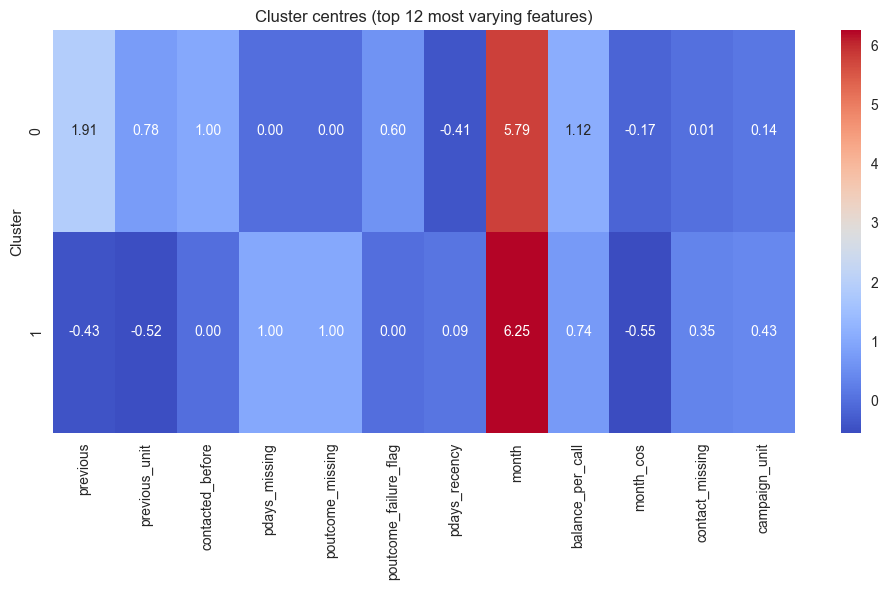

In [15]:
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centers_df = pd.DataFrame(centroids_original, columns=feature_columns)

variability = centers_df.var().sort_values(ascending=False)
top_features = variability.head(12).index

plt.figure(figsize=(10, 6))
sns.heatmap(centers_df[top_features], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cluster centres (top 12 most varying features)")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

### 4.5 Cluster size distribution

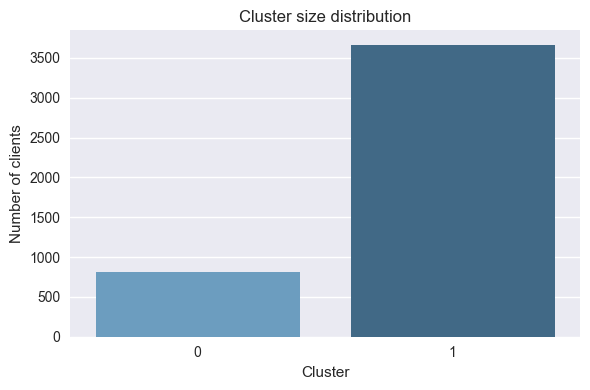

In [26]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x=cluster_sizes.index,
    y=cluster_sizes.values,
    hue=cluster_sizes.index,
    palette="Blues_d",
    legend=False
)
plt.title("Cluster size distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.show()


### 4.6 Radar chart for headline features

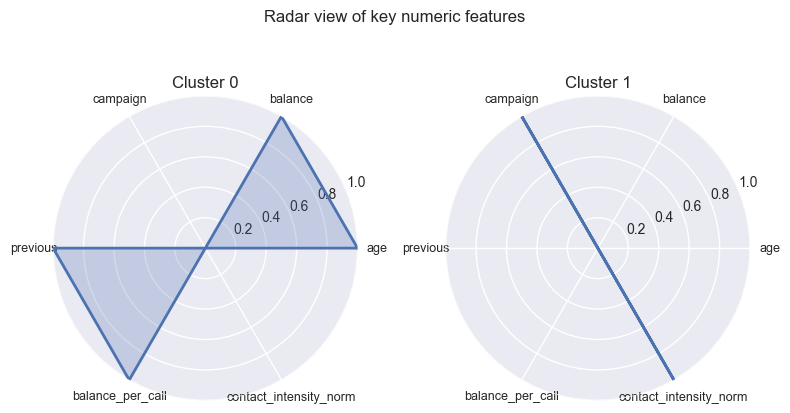

In [17]:
radar_features = ["age", "balance", "campaign", "previous", "balance_per_call", "contact_intensity_norm"]
cluster_feature_means = df_clusters.groupby("cluster")[radar_features].mean()

radar_min = cluster_feature_means.min()
radar_max = cluster_feature_means.max()
radar_normalised = (cluster_feature_means - radar_min) / (radar_max - radar_min + 1e-8)

labels = radar_features
num_features = len(labels)
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

fig, axes = plt.subplots(1, best_k, subplot_kw=dict(polar=True), figsize=(4 * best_k, 4))
if best_k == 1:
    axes = [axes]

for ax, (cluster_id, row) in zip(axes, radar_normalised.iterrows()):
    values = np.concatenate((row.values, [row.values[0]]))
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_title(f"Cluster {cluster_id}")
    ax.set_ylim(0, 1)

plt.suptitle("Radar view of key numeric features", y=1.05)
plt.tight_layout()
plt.show()

## 5. Dimensionality Reduction Visualisations

We project the high-dimensional feature space to 2D/3D using PCA, t-SNE, and MDS to visually inspect the separation between clusters.

### 5.1 Principal Component Analysis (2D & 3D)

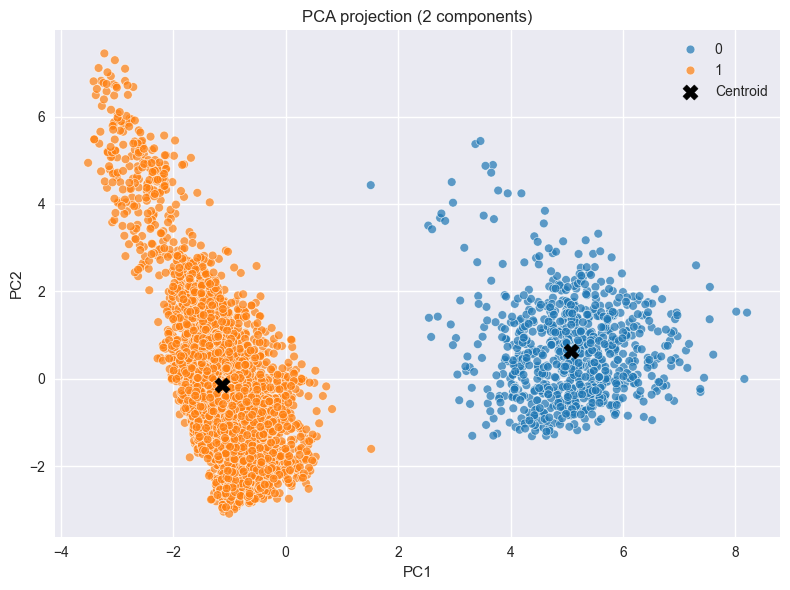

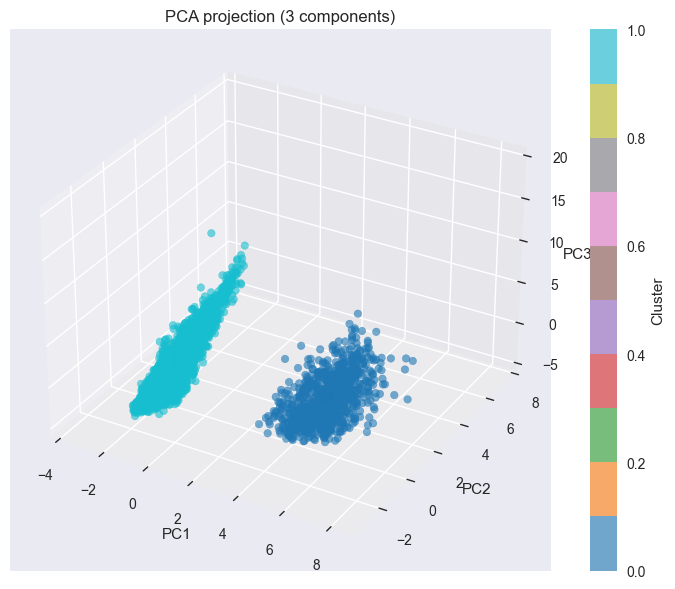

In [18]:
pca_2d = PCA(n_components=2, random_state=42)
pca_coords = pca_2d.fit_transform(X_scaled)
centroids_pca = pca_2d.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_coords[:, 0], y=pca_coords[:, 1], hue=cluster_labels, palette="tab10", s=40, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c="black", s=120, marker="X", label="Centroid")
plt.title("PCA projection (2 components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

pca_3d = PCA(n_components=3, random_state=42)
pca_coords_3d = pca_3d.fit_transform(X_scaled)
centroids_pca3 = pca_3d.transform(kmeans_final.cluster_centers_)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(pca_coords_3d[:, 0], pca_coords_3d[:, 1], pca_coords_3d[:, 2], c=cluster_labels, cmap="tab10", s=30, alpha=0.6)
ax.scatter(centroids_pca3[:, 0], centroids_pca3[:, 1], centroids_pca3[:, 2], c="black", s=150, marker="X", label="Centroid")
ax.set_title("PCA projection (3 components)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
fig.colorbar(scatter, ax=ax, label="Cluster")
plt.tight_layout()
plt.show()

### 5.2 t-SNE embedding

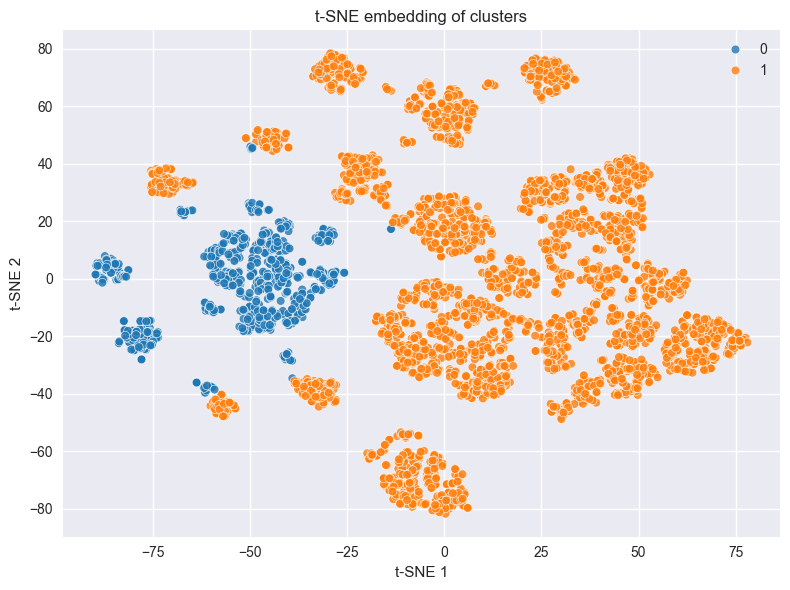

In [19]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, init="pca")
tsne_coords = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_coords[:, 0], y=tsne_coords[:, 1], hue=cluster_labels, palette="tab10", s=40, alpha=0.8)
plt.title("t-SNE embedding of clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()

### 5.3 Multidimensional Scaling (MDS)

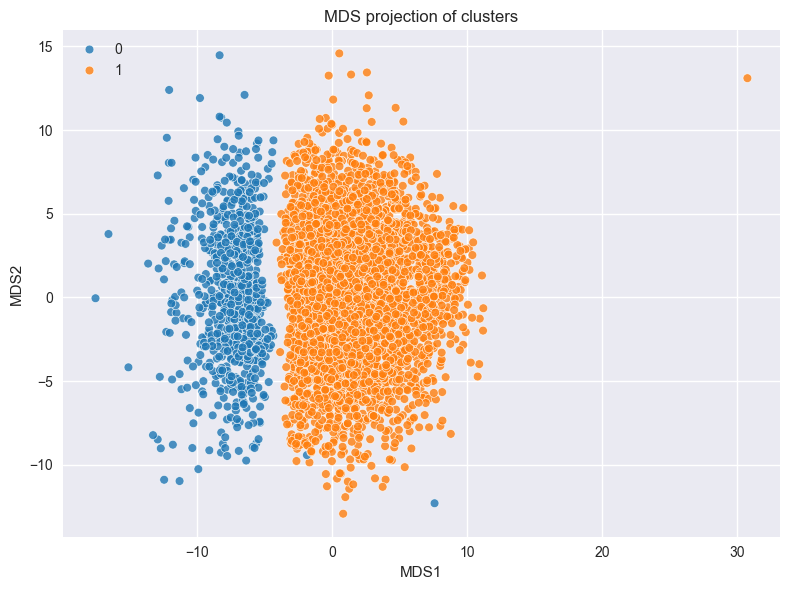

In [20]:
mds = MDS(n_components=2, random_state=42, n_init=4, max_iter=300)
mds_coords = mds.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=mds_coords[:, 0], y=mds_coords[:, 1], hue=cluster_labels, palette="tab10", s=40, alpha=0.8)
plt.title("MDS projection of clusters")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Comparative & Statistical Validation

Finally, we benchmark against random clustering, run statistical separation checks, and connect the findings back to business relevance.

### 7.1 Random clustering baseline

In [23]:
rng = np.random.default_rng(42)
random_labels = rng.integers(0, best_k, size=X_scaled.shape[0])
random_baseline = {
    "silhouette": silhouette_score(X_scaled, random_labels),
    "calinski_harabasz": calinski_harabasz_score(X_scaled, random_labels),
    "davies_bouldin": davies_bouldin_score(X_scaled, random_labels),
}

actual_metrics = {
    "silhouette": silhouette_score(X_scaled, cluster_labels),
    "calinski_harabasz": calinski_harabasz_score(X_scaled, cluster_labels),
    "davies_bouldin": davies_bouldin_score(X_scaled, cluster_labels),
}

comparison_df = pd.DataFrame([actual_metrics, random_baseline], index=["KMeans", "Random"])
comparison_df

,silhouette,calinski_harabasz,davies_bouldin
KMeans,0.253785,776.934748,1.867647
Random,0.000064,0.816367,70.436087


### 7.2 Statistical separation tests

In [24]:
anova_features = ["age", "balance", "campaign", "previous", "balance_per_call", "contact_intensity_norm"]
anova_rows = []
for feature in anova_features:
    groups = [df_clusters[df_clusters["cluster"] == cid][feature] for cid in sorted(df_clusters["cluster"].unique())]
    stat, p_value = f_oneway(*groups)
    anova_rows.append({"feature": feature, "F_statistic": stat, "p_value": p_value})

anova_results = pd.DataFrame(anova_rows).round(4)
anova_results

,feature,F_statistic,p_value
0,age,1.1924,0.2749
1,balance,10.4822,0.0012
2,campaign,82.1365,0.0000
3,previous,19720.6863,0.0000
4,balance_per_call,12.4579,0.0004
5,contact_intensity_norm,601.5084,0.0000


### 7.3 Centre separation diagnostics

In [25]:
centre_distances = pairwise_distances(kmeans_final.cluster_centers_)
centre_distance_df = pd.DataFrame(centre_distances, columns=[f"cluster_{i}" for i in range(best_k)], index=[f"cluster_{i}" for i in range(best_k)])
centre_distance_df

,cluster_0,cluster_1
cluster_0,0.000000,6.300878
cluster_1,6.300878,0.000000


## 8. Deliverables & Next Steps

- **Technical artefacts**: this notebook (methodology + code), metric tables, and generated visualisations.
- **Executive summary**: use the narrative cues to craft a short leadership-friendly brief.
- **Cluster profile database**: export `df_clusters` with the assigned labels for campaign targeting.
- **Strategic roadmap**: prioritise segments with high conversion potential and resource requirements informed by the KPI table.
- **Monitoring**: track subscription rate by cluster, campaign contact efficiency, and movement between clusters over time.

> Success criteria recap: a defensible value of *k*, statistically separated clusters, and recommendations that marketing teams can activate with clear KPIs.